In [1]:
%load_ext autoreload
%autoreload 2

import IPython
from pathlib import Path
import os
locals = IPython.extract_module_locals() # type: ignore
notebook_name = "/".join(locals[1]["__vsc_ipynb_file__"].split("/"))
os.chdir(Path(notebook_name).parent.parent)

In [2]:
from typing import Callable, Any
from pathlib import Path

import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

seed = 0
random.seed(seed)
np.random.seed(seed)

In [3]:
relations = pl.read_parquet(".data/hm/intermediate/full/relations.parquet")
users = pl.read_parquet(".data/hm/intermediate/full/users.parquet")
items = pl.read_parquet(".data/hm/intermediate/full/articles.parquet")

In [4]:
n_users = relations.get_column("customer_id_map").n_unique()
n_items = items.get_column('article_id').n_unique()
relations_n_users = relations.get_column("customer_id").n_unique()
relations_n_items = relations.get_column("article_id").n_unique()

In [5]:
n_users

1362281

In [6]:
u_f = 0.01

relations_filtered = relations.join(relations.select("customer_id_map").unique().sample(fraction=u_f), on="customer_id_map", how="right")
relations_filtered_n_users = relations_filtered.get_column("customer_id").n_unique()
relations_filtered_n_items = relations_filtered.get_column("article_id").n_unique()

In [7]:
print(f"""(Users) Nunique: {n_users}
(Items) Nunique: {n_items}
(Relations, Users) Nunique: {relations_n_users} | diff: {n_users - relations_n_users}
(Relations, Items) Nunique: {relations_n_items} | diff: {n_items - relations_n_items}
(Relations, Users) Nunique (filtered): {relations_filtered_n_users} | diff: {n_users - relations_filtered_n_users}
(Relations, Items) Nunique (filtered): {relations_filtered_n_items} | diff: {n_items - relations_filtered_n_items}""")

(Users) Nunique: 1362281
(Items) Nunique: 105542
(Relations, Users) Nunique: 1362281 | diff: 0
(Relations, Items) Nunique: 104547 | diff: 995
(Relations, Users) Nunique (filtered): 13622 | diff: 1348659
(Relations, Items) Nunique (filtered): 51641 | diff: 53901


In [8]:
relations_filtered.shape

(315187, 7)

(array([2.547e+03, 9.400e+02, 1.548e+03, 5.450e+02, 9.110e+02, 3.710e+02,
        6.840e+02, 2.810e+02, 4.780e+02, 2.480e+02, 3.820e+02, 2.080e+02,
        3.150e+02, 1.550e+02, 2.770e+02, 1.170e+02, 2.150e+02, 1.130e+02,
        1.980e+02, 9.300e+01, 1.730e+02, 8.200e+01, 1.790e+02, 6.700e+01,
        6.900e+01, 1.610e+02, 6.300e+01, 1.320e+02, 5.700e+01, 1.150e+02,
        4.500e+01, 1.040e+02, 6.200e+01, 9.400e+01, 3.800e+01, 6.700e+01,
        3.700e+01, 7.000e+01, 2.600e+01, 5.900e+01, 3.000e+01, 5.600e+01,
        3.000e+01, 6.300e+01, 2.400e+01, 5.200e+01, 3.000e+01, 5.500e+01,
        1.900e+01, 2.500e+01, 4.000e+01, 2.100e+01, 4.200e+01, 1.800e+01,
        3.400e+01, 1.700e+01, 2.300e+01, 1.900e+01, 3.200e+01, 1.900e+01,
        2.600e+01, 1.700e+01, 2.400e+01, 7.000e+00, 1.400e+01, 1.100e+01,
        2.600e+01, 4.000e+00, 1.200e+01, 8.000e+00, 1.900e+01, 1.200e+01,
        1.200e+01, 1.000e+01, 5.000e+00, 1.900e+01, 7.000e+00, 1.600e+01,
        4.000e+00, 1.300e+01, 7.000e+0

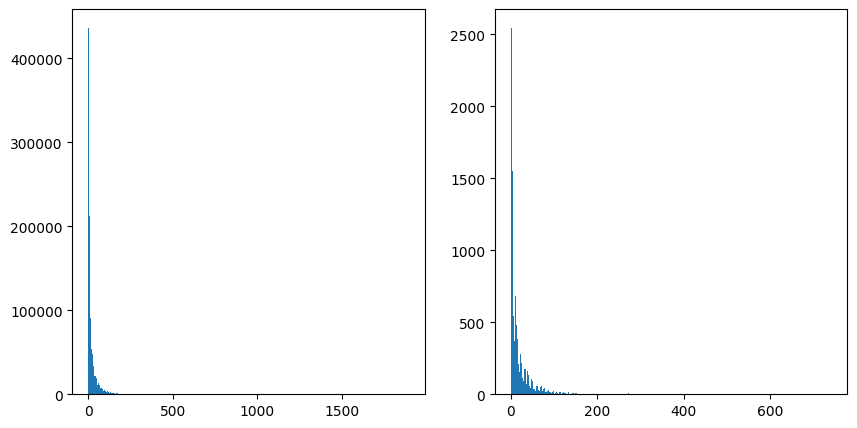

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

relations_cnt = relations.group_by("customer_id_map").agg(pl.len()).sort("len", descending=True)
relations_filtered_cnt = relations_filtered.group_by("customer_id_map").agg(pl.len()).sort("len", descending=True)
ax[0].hist(relations_cnt.select("len"), bins=500)
ax[1].hist(relations_filtered_cnt.select("len"), bins=500)

In [10]:
users_filtered = users.join(relations_filtered.select("customer_id").unique(), on="customer_id", how="inner").drop("customer_id_map")
items_filtered = items.join(relations_filtered.select("article_id").unique(), on="article_id", how="inner")

In [11]:
users_filtered = users_filtered.with_columns(customer_id_map=pl.col("customer_id").cast(pl.Categorical).to_physical())
items_filtered = items_filtered.with_columns(article_id_map=pl.col("article_id").cast(pl.String).cast(pl.Categorical).to_physical())

users_id_map = users_filtered.select("customer_id", "customer_id_map").unique()
articles_id_map = items_filtered.select("article_id", "article_id_map").unique()
for c, id_map in zip(["customer_id", "article_id"], [users_id_map, articles_id_map]):
    id_map.write_parquet(f".data/hm/intermediate/frac_0_01/{c}_map.parquet")

In [12]:
relations_filtered = relations_filtered.drop("customer_id_map", "article_id_map") \
    .sort("t_dat") \
    .join(users_id_map, on="customer_id", how="left") \
    .join(articles_id_map, on="article_id", how="left")

In [26]:
# Write files to parquet
users_filtered.write_parquet(".data/hm/intermediate/frac_0_01/users.parquet")
items_filtered.write_parquet(".data/hm/intermediate/frac_0_01/articles.parquet")
relations_filtered.write_parquet(".data/hm/intermediate/frac_0_01/relations.parquet")